<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

In [102]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv

File ‘DAYTON_hourly.csv’ already there; not retrieving.



In [103]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

#data.resample('3H').sum()
#data = data.resample('6H').sum()
data = data.resample('12H').sum()
#data.resample('1D').sum()
#data.resample('1W').sum()
#data.resample('1Y').sum()
#data.groupby([data.index.year == 2015,data.index.month <3 ])['DAYTON_MW'].sum()

In [104]:
data.shape

(10109, 1)

In [105]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-08-01 00:00:00,22046.0
2018-08-01 12:00:00,27401.0
2018-08-02 00:00:00,22058.0
2018-08-02 12:00:00,29979.0
2018-08-03 00:00:00,2042.0


Preprocessing

- Normalize the dataset

In [106]:
data = data[data.index.year >= 2008]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

Hyperparameters

In [107]:
n_steps_in = 24
lag = 0

n_epochs = 1
learn_rate = 0.002  

Create model

In [108]:
lstm_model = Sequential()

lstm_model.add( LSTM(40, activation="tanh", return_sequences=True, input_shape = (n_steps_in, 1)) )
lstm_model.add( Dropout(0.15) )

lstm_model.add( LSTM(40, activation="tanh", return_sequences=True) )
lstm_model.add( Dropout(0.15) )

lstm_model.add( LSTM(40, activation="tanh", return_sequences=False) )
lstm_model.add( Dropout(0.15) )

lstm_model.add( Dense(1) )              # Wrapper


# Define the optimizer and compile.
my_optimizer=Adam(lr=learn_rate)
lstm_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


- Splitting the training and test sets

In [109]:
# look_back refers to the timesteps

def split_sequence(sequence, n_steps_in, n_steps_out = 1, lag = 0):
  X, y = list(), list()
  i = 0
  while i < len(sequence):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    # check if we are beyond the sequence
    if out_end_ix + lag > len(sequence):
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lag:out_end_ix + lag]
    i = i + n_steps_out
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)

In [110]:
train, test = train_test_split(normalized_data, test_size = 0.2, shuffle = False)
print(len(data), len(train), len(test))

7735 6188 1547


In [111]:
# split into samples
trainX, trainY = split_sequence(train, n_steps_in)
testX, testY = split_sequence(test, n_steps_in)

In [112]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
# https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

In [113]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 24, 40)            6720      
                                                                 
 dropout_12 (Dropout)        (None, 24, 40)            0         
                                                                 
 lstm_13 (LSTM)              (None, 24, 40)            12960     
                                                                 
 dropout_13 (Dropout)        (None, 24, 40)            0         
                                                                 
 lstm_14 (LSTM)              (None, 40)                12960     
                                                                 
 dropout_14 (Dropout)        (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Train model

In [126]:
%%time
summary = lstm_model.fit(trainX, trainY, epochs=n_epochs, batch_size = 1)

6164/6164 [==============================] - 100s 16ms/step - loss: 0.0033 - mse: 0.0033
CPU times: user 1min 41s, sys: 6.22 s, total: 1min 48s
Wall time: 2min 22s


In [115]:
#my_model.save('LSTM_model.h5')
#my_model = load_model('LSTM_model.h5')

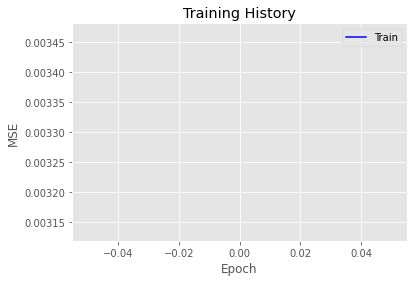

In [127]:
plt.plot(summary.history['loss'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

Predict

In [117]:
# make predictions
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [118]:
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
#trainY = scaler.inverse_transform(trainY.reshape(-1,1))
#testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
#testY = scaler.inverse_transform(testY.reshape(-1,1))

In [119]:
trainPredict.shape[:]

(6164, 1)

Evaluate predictions

In [120]:
trainRMSE = np.sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (trainRMSE))

testRMSE = np.sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (testRMSE))

Test Score:
   0.094 RMSE
Test Score:
   0.097 RMSE


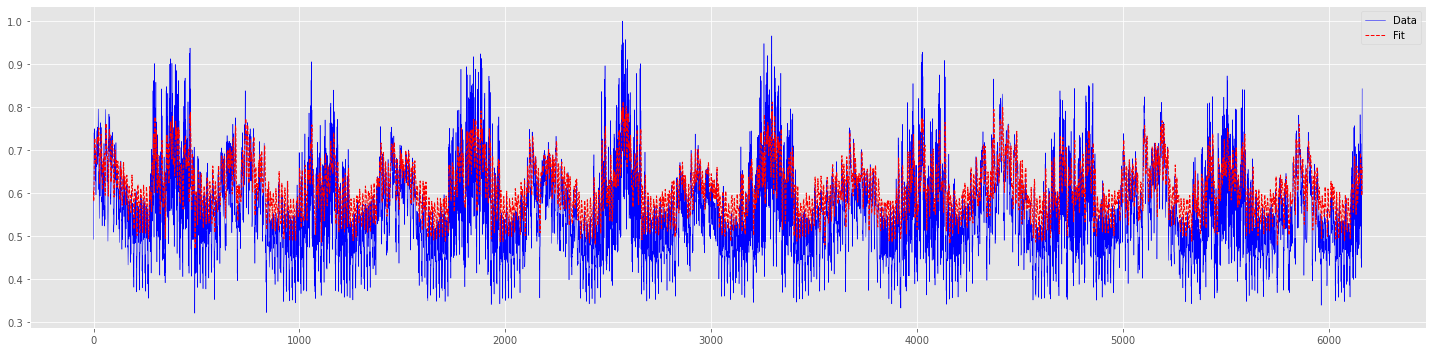

In [121]:
# Compare the training preditiction

plt.figure(figsize = (20, 5))

plt.plot(trainY[:, 0, 0], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(trainPredict[:,0], c='r',linewidth=1, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

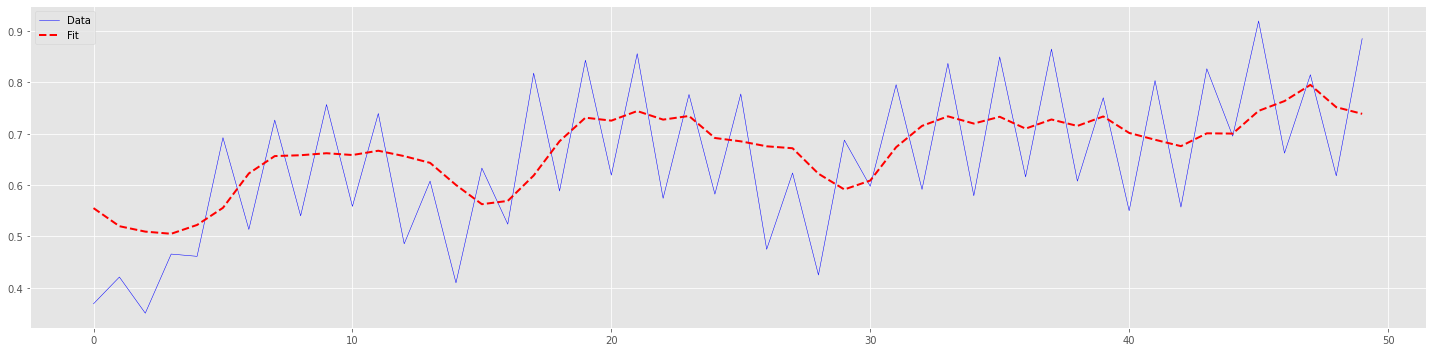

In [122]:
# Compare the test prediction

plt.figure(figsize = (20, 5))

plt.plot(testY[:50, 0, 0], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(testPredict[:50,0], c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()